In [ ]:
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.3.1

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
use_gdrive = True

folder_path = ""

if use_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')
  folder_path = "/content/drive/MyDrive/projects/nlp_disaster_tweets/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [35]:
train_df = pd.read_csv(folder_path + "data/train_extracted_locations.csv")

test_df = pd.read_csv(folder_path + "data/test_extracted_locations.csv")
sample_submission = pd.read_csv(folder_path + "data/original/sample_submission.csv")

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("Sample submission shape:", sample_submission.shape)

Training data shape: (7634, 8)
Test data shape: (3269, 7)
Sample submission shape: (3263, 2)


In [36]:
train_df[100:110]


,id,keyword,location,text,target,city,country,continent
100,144,accident,UK,.@NorwayMFA #Bahrain police had previously die...,1,NaN,United Kingdom,Europe
101,145,accident,"Nairobi, Kenya",I still have not heard Church Leaders of Kenya...,0,Nairobi,Kenya,Africa
102,146,aftershock,Instagram - @heyimginog,@afterShock_DeLo scuf ps live and the game... cya,0,NaN,NaN,NaN
103,149,aftershock,304,'The man who can drive himself further once th...,0,NaN,NaN,NaN
104,151,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...,0,NaN,Switzerland,Europe
105,153,aftershock,304,'There is no victory at bargain basement price...,0,NaN,NaN,NaN
106,156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,NaN,United States,North America
107,157,aftershock,304,'Nobody remembers who came in second.' Charles...,0,NaN,NaN,NaN
108,158,aftershock,Instagram - @heyimginog,@afterShock_DeLo im speaking from someone that...,0,NaN,NaN,NaN
109,159,aftershock,304,'The harder the conflict the more glorious the...,0,NaN,NaN,NaN


In [37]:
test_df[100:110]

,id,keyword,location,text,city,country,continent
100,339,annihilated,NaN,BROOO HE JUST GOT ANNIHILATED https://t.co/UR7...,NaN,NaN,NaN
101,342,annihilated,"Salem, MA",@AlbertBreer he was probably annihilated neede...,Salem,United States,North America
102,343,annihilated,"Chicago, Illinois",$GMCR no longe rGreen mountain now Red Mountai...,Chicago,United States,North America
103,350,annihilation,NaN,Please sign &amp; RT to save #SaltRiverWildHor...,NaN,NaN,NaN
104,351,annihilation,NaN,Allied Plans for the Annihilation of the Germa...,NaN,NaN,NaN
105,357,annihilation,"Yeezy Taught Me , NV",Please share and sign this petition to save wi...,NaN,United States,North America
106,359,annihilation,Colorado,U.S National Park Services Tonto National Fore...,NaN,United States,North America
107,362,annihilation,United States,NEW! Are souls punished with annihilation? htt...,NaN,United States,North America
108,366,annihilation,High Desert,***Latest Updates on the Salt River Wild Horse...,NaN,NaN,NaN
109,367,annihilation,"Plovdiv, Bulgaria",U.S National Park Services Tonto National Fore...,Plovdiv,Bulgaria,Europe


In [38]:
# this is a template with all target values as 0
sample_submission[100:110]

,id,target
100,339,0
101,342,0
102,343,0
103,350,0
104,351,0
105,357,0
106,359,0
107,362,0
108,366,0
109,367,0


We account for a small mismatch with the augmented data, there are a few extra rows.

In [39]:
test_df = test_df[test_df['id'].isin(sample_submission['id'])].drop_duplicates(subset='id')

In [40]:
test_df.shape

(3263, 7)

In [41]:
sample_submission.shape

(3263, 2)

# Preprocessing

We fill the null values with an empty string

In [42]:
print("Missing values in 'location' (train):", train_df['location'].isnull().sum())
print("Missing values in 'city' (train):", train_df['city'].isnull().sum())
print("Missing values in 'country' (train):", train_df['country'].isnull().sum())
print("Missing values in 'continent' (train):", train_df['continent'].isnull().sum())

print("Missing values in 'location' (test):", test_df['location'].isnull().sum())
print("Missing values in 'city' (test):", test_df['city'].isnull().sum())
print("Missing values in 'country' (test):", test_df['country'].isnull().sum())
print("Missing values in 'continent' (test):", test_df['continent'].isnull().sum())

Missing values in 'location' (train): 2533
Missing values in 'city' (train): 4996
Missing values in 'country' (train): 4026
Missing values in 'continent' (train): 4018
Missing values in 'location' (test): 1105
Missing values in 'city' (test): 2137
Missing values in 'country' (test): 1731
Missing values in 'continent' (test): 1736


In [43]:
train_df['location'] = train_df['location'].fillna('')
train_df['city'] = train_df['city'].fillna('')
train_df['country'] = train_df['country'].fillna('')
train_df['continent'] = train_df['continent'].fillna('')
test_df['location'] = test_df['location'].fillna('')
test_df['city'] = test_df['city'].fillna('')
test_df['country'] = test_df['country'].fillna('')
test_df['continent'] = test_df['continent'].fillna('')

In [44]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(word) for word in tokens]
    text = ' '.join(tokens)
    return text

We clean the values for `text` and store them in `clean_text`

In [45]:
train_df['clean_text'] = train_df['text'].apply(preprocess_text)
test_df['clean_text'] = test_df['text'].apply(preprocess_text)

In `combined_text` we combine the data from all the columns into a single string that we'll tokenize.

In [46]:
train_df['combined_text'] = train_df['keyword'].fillna('') + ' ' + train_df['clean_text'] + ' - ' + train_df['city'] + ' ' + train_df['country'] + ' ' + train_df['continent']
test_df['combined_text'] = test_df['keyword'].fillna('') + ' ' + test_df['clean_text'] + ' - ' + test_df['city'] + ' ' + test_df['country'] + ' ' + test_df['continent']

In [47]:
train_df['combined_text'][101]

'accident still heard church leader kenya come forward comment accid issu disciplinari measur - Nairobi Kenya Africa'

## Text Vectorization

We convert the text data from `combined_text` into vectors using **TF-IDF** (a statistical measure that reflects how important a word is in a document relative to a collection of documents).

- **`ngram_range=(1,2)`**: Considers both individual words (**unigrams**) and pairs of words (**bigrams**) as features.
- **`max_features=10000`**: Limits the number of features (words and bigrams) to the 10,000 most frequent ones, reducing dimensionality and preventing overfitting.

### **Text and Target Extraction**
- **`X_text`**: Stores the raw text data from `train_df['combined_text']`, which will be transformed using TF-IDF.
- **`y`**: Stores the target labels from `train_df['target']`, where:
  - `1` → Indicates a real disaster-related tweet.
  - `0` → Indicates a non-disaster tweet.
- **`X_submission_text`**: Stores the raw text data from `test_df['combined_text']`, which will be transformed using TF-IDF.
  
These variables will be used for further processing, including **splitting into training, validation, and test sets** before applying the TF-IDF transformation.

In [48]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000)

X_text = train_df['combined_text'].values
y = train_df['target'].values

X_submission_text = test_df['combined_text'].values

Splitting the Dataset into Training, Validation, and Test Sets:

1. **Creating a Separate Test Set**
   - `train_test_split(..., test_size=0.1)`: Reserves **10% of the dataset** for final testing (`X_test`, `y_test`).
   - Ensures we have a labeled test set instead of relying on external datasets.

2. **Splitting Training and Validation Sets**
   - `train_test_split(..., test_size=0.2)`: Further splits the **remaining 90%** into:
     - **80% for training (`X_train`, `y_train`)**
     - **20% for validation (`X_val`, `y_val`)**
   - `stratify=y_train_val`: Ensures class distribution remains balanced across training and validation sets.

### **Variables:**
- **`X_train`**: Features (raw text) for the training set.
- **`X_val`**: Features for the validation set.
- **`X_test`**: Features for the test set. **We do not use the `test_df` for this since we don't have the real target values, we will use the `test_df` later to create the submission csv**
- **`y_train`**: Target labels (0 = not a disaster, 1 = disaster) for the training set.
- **`y_val`**: Target labels for the validation set.
- **`y_test`**: Target labels for the test set.

This structure ensures that our **test data remains unseen until final evaluation**, while the validation set is used for hyperparameter tuning.

In [49]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_text, y, test_size=0.1, random_state=42, stratify=y  # 10% for testing
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val  # 20% of remaining for validation
)

In [50]:
X_train = tfidf.fit_transform(X_train)
X_val = tfidf.transform(X_val)
X_test = tfidf.transform(X_test)
X_submission = tfidf.transform(X_submission_text)

feature_names = tfidf.get_feature_names_out()

In [51]:
X_train_df = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_val_df = pd.DataFrame(X_val.toarray(), columns=feature_names)
X_test_df = pd.DataFrame(X_test.toarray(), columns=feature_names)

print("Train TF-IDF Matrix:")
display(X_train_df.head())

print("\nValidation TF-IDF Matrix:")
display(X_val_df.head())

print("\nTest TF-IDF Matrix:")
display(X_test_df.head())


Train TF-IDF Matrix:


,20accident,20accident airplan,20accident expert,20accident horribl,20bag,20bag check,20bag loui,20bag new,20bagging,20bagging bodi,...,zealand oceania,zero,zionist,zip,zombi,zombi apocalyps,zone,zone come,zouma,zouma flatten
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Validation TF-IDF Matrix:


,20accident,20accident airplan,20accident expert,20accident horribl,20bag,20bag check,20bag loui,20bag new,20bagging,20bagging bodi,...,zealand oceania,zero,zionist,zip,zombi,zombi apocalyps,zone,zone come,zouma,zouma flatten
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Test TF-IDF Matrix:


,20accident,20accident airplan,20accident expert,20accident horribl,20bag,20bag check,20bag loui,20bag new,20bagging,20bagging bodi,...,zealand oceania,zero,zionist,zip,zombi,zombi apocalyps,zone,zone come,zouma,zouma flatten
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Traditional Models

In [52]:
results = {}

**StratifiedKFold**: Technique used to evaluate the performance of a machine learning model. It works by splitting the data into multiple folds (subsets) and then repeatedly training and testing the model on different combinations of these folds. The "stratified" part ensures that each fold has roughly the same proportion of data from each class (in this case, disaster or not disaster tweets), which is important for balanced evaluation, especially when dealing with imbalanced datasets.

`n_splits=5`: Number of folds to create.

`shuffle=True`: Shuffle the data before splitting it into folds, it helps to randomize the data and reduce the potential for bias in the model evaluation.


In [53]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [54]:
models = {}

`evaluate_model`: evaluates a machine learning model using two approaches:
1. **With Cross-Validation (CV):** The model is evaluated using K-Fold cross-validation, providing an average accuracy score
   and a classification report based on cross-validation predictions.
2. **Without Cross-Validation:** The model is trained on the full training set and evaluated separately on a validation set,
   providing accuracy scores and a classification report for both training and validation predictions.

The results include:
- Cross-validation accuracy and classification report.
- Training accuracy, validation accuracy, and classification report.
- Predictions for both cross-validation and direct training/validation.


In [55]:
def evaluate_model(model, model_name, X_train, y_train, X_val, y_val, skf):
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    y_pred_cv = cross_val_predict(model, X_train, y_train, cv=skf)
    cv_report = pd.DataFrame(classification_report(y_train, y_pred_cv, output_dict=True)).transpose()

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    val_report = pd.DataFrame(classification_report(y_val, y_pred_val, output_dict=True)).transpose()

    return {
        'model_name': model_name,
        'model': model,
        'cv_results': {
            'cv_mean_accuracy': cv_scores.mean(),
            'cv_scores': cv_scores,
            'cv_predictions': y_pred_cv,
            'cv_report': cv_report
        },
        'train_val_results': {
            'training_accuracy': accuracy_train,
            'validation_accuracy': accuracy_val,
            'training_predictions': y_pred_train,
            'validation_predictions': y_pred_val,
            'validation_report': val_report
        }
    }


## Decision Tree

In [56]:
dt = DecisionTreeClassifier(random_state=42)
results["decision_tree"] = evaluate_model(dt, 'Decision Tree', X_train, y_train, X_val, y_val, skf)



- **Precision**: The proportion of positive predictions that were actually correct. A higher precision means fewer false positives.
- **Recall**: The proportion of actual positives that were correctly identified. A higher recall means fewer false negatives.
- **F1-Score**: The harmonic mean of precision and recall. It balances both metrics (especially useful when the dataset is imbalanced).
- **Support**: The number of actual instances of each class in the dataset.
- **Accuracy**: The overall proportion of correctly classified instances.
- **Macro Average**: The average of precision, recall, and F1-score across all classes, treating each class equally.
- **Weighted Average**: Similar to macro average but weights each class based on its frequency in the dataset, making it more representative for imbalanced data.

In [57]:
print("\nDecision Tree Results:")

print("\nCross-Validation Report:")
print(results["decision_tree"]["cv_results"]["cv_report"])
print("Mean Cross-Validation Accuracy:", results["decision_tree"]["cv_results"]["cv_mean_accuracy"])

print("\nTrain-Validation Results:")
print("Training Accuracy:", results["decision_tree"]["train_val_results"]["training_accuracy"])
print("Validation Accuracy:", results["decision_tree"]["train_val_results"]["validation_accuracy"])
print("\nValidation Classification Report:")
print(results["decision_tree"]["train_val_results"]["validation_report"])


Decision Tree Results:

Cross-Validation Report:
              precision    recall  f1-score      support
0              0.748497  0.755428  0.751947  3132.000000
1              0.671949  0.663706  0.667802  2364.000000
accuracy       0.715975  0.715975  0.715975     0.715975
macro avg      0.710223  0.709567  0.709874  5496.000000
weighted avg   0.715571  0.715975  0.715753  5496.000000
Mean Cross-Validation Accuracy: 0.7159748531723054

Train-Validation Results:
Training Accuracy: 0.9909024745269287
Validation Accuracy: 0.7190684133915575

Validation Classification Report:
              precision    recall  f1-score      support
0              0.742962  0.775223  0.758750   783.000000
1              0.684022  0.644670  0.663763   591.000000
accuracy       0.719068  0.719068  0.719068     0.719068
macro avg      0.713492  0.709947  0.711257  1374.000000
weighted avg   0.717610  0.719068  0.717893  1374.000000


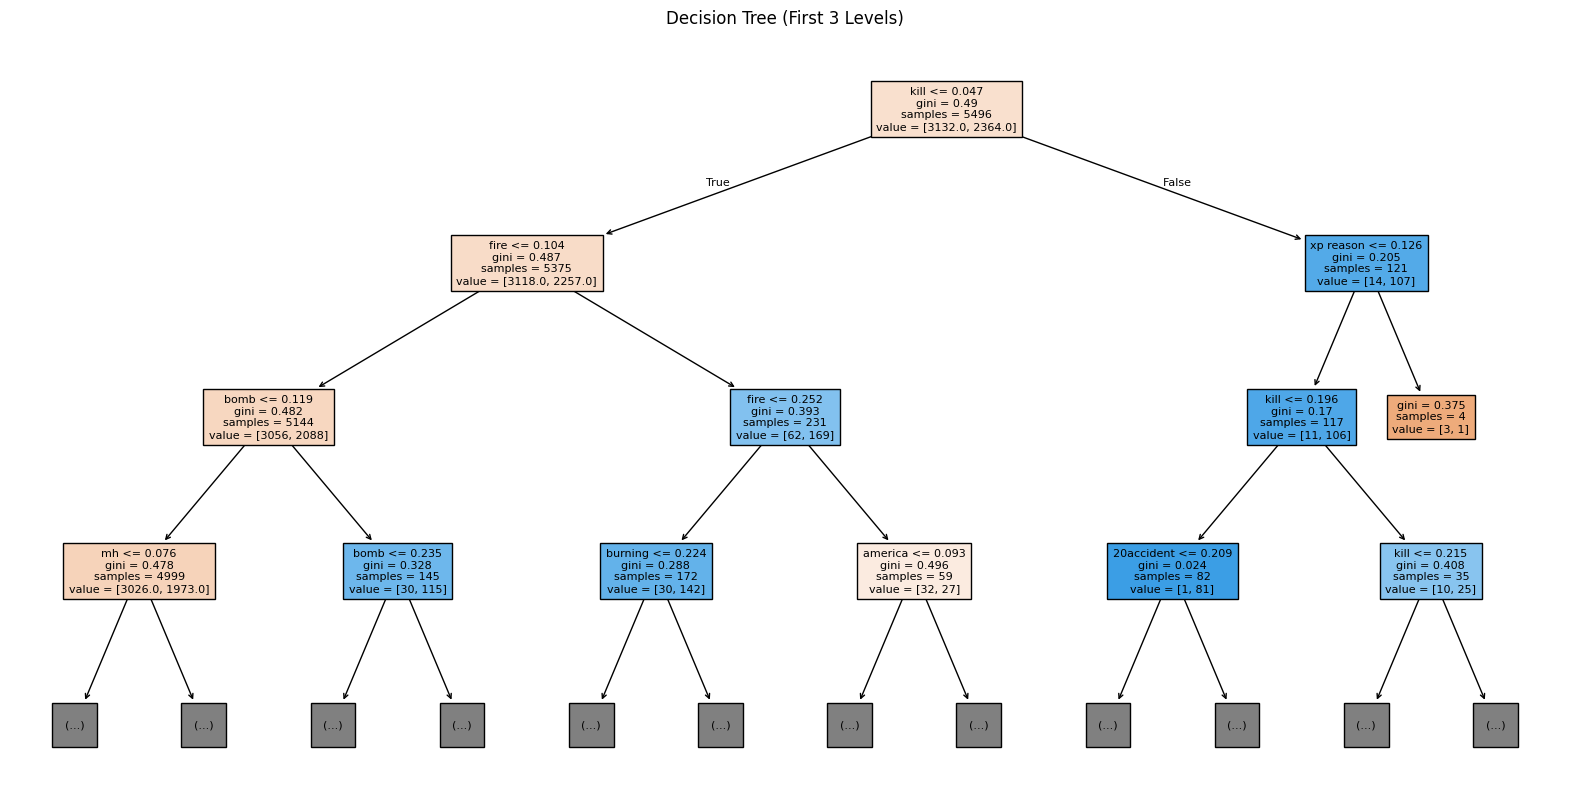

In [58]:
plt.figure(figsize=(20,10))
plot_tree(results["decision_tree"]['model'], max_depth=3, feature_names=tfidf.get_feature_names_out(), filled=True, fontsize=8)
plt.title('Decision Tree (First 3 Levels)')
plt.show()


## Random Forest

In [59]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
results["random_forest"] = evaluate_model(rf, 'Random Forest', X_train, y_train, X_val, y_val, skf)

In [60]:
print("\nRandom Forest Results:")

print("\nCross-Validation Report:")
print(results["random_forest"]["cv_results"]["cv_report"])
print("Mean Cross-Validation Accuracy:", results["random_forest"]["cv_results"]["cv_mean_accuracy"])

print("\nTrain-Validation Results:")
print("Training Accuracy:", results["random_forest"]["train_val_results"]["training_accuracy"])
print("Validation Accuracy:", results["random_forest"]["train_val_results"]["validation_accuracy"])
print("\nValidation Classification Report:")
print(results["random_forest"]["train_val_results"]["validation_report"])



Random Forest Results:

Cross-Validation Report:
              precision    recall  f1-score      support
0              0.752677  0.897829  0.818870  3132.000000
1              0.818182  0.609137  0.698351  2364.000000
accuracy       0.773654  0.773654  0.773654     0.773654
macro avg      0.785429  0.753483  0.758611  5496.000000
weighted avg   0.780852  0.773654  0.767031  5496.000000
Mean Cross-Validation Accuracy: 0.7736553891967904

Train-Validation Results:
Training Accuracy: 0.9907205240174672
Validation Accuracy: 0.7554585152838428

Validation Classification Report:
              precision    recall  f1-score      support
0              0.742671  0.873563  0.802817   783.000000
1              0.781457  0.598985  0.678161   591.000000
accuracy       0.755459  0.755459  0.755459     0.755459
macro avg      0.762064  0.736274  0.740489  1374.000000
weighted avg   0.759354  0.755459  0.749198  1374.000000


`feature_importances`: indicates the relative importance of each feature in making predictions.
Higher values mean the feature contributes more to the model’s decision-making.


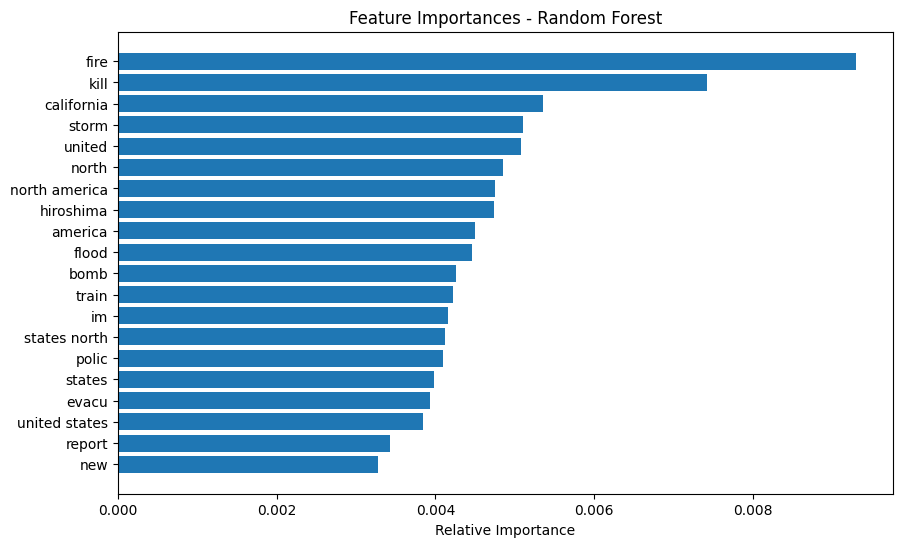

In [61]:
importances = results['random_forest']['model'].feature_importances_
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10,6))
plt.title('Feature Importances - Random Forest')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [tfidf.get_feature_names_out()[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


## SVM

Linear SVC (Support Vector Classification) is a linear classifier that finds the optimal hyperplane to separate data points for classification.


In [62]:
svc = LinearSVC(random_state=42)
results["svc"] = evaluate_model(svc, 'Linear SVC', X_train, y_train, X_val, y_val, skf)

In [63]:
print("\nLinear SVC Results:")

print("\nCross-Validation Report:")
print(results["svc"]["cv_results"]["cv_report"])
print("Mean Cross-Validation Accuracy:", results["svc"]["cv_results"]["cv_mean_accuracy"])

print("\nTrain-Validation Results:")
print("Training Accuracy:", results["svc"]["train_val_results"]["training_accuracy"])
print("Validation Accuracy:", results["svc"]["train_val_results"]["validation_accuracy"])
print("\nValidation Classification Report:")
print(results["svc"]["train_val_results"]["validation_report"])


Linear SVC Results:

Cross-Validation Report:
              precision    recall  f1-score      support
0              0.788724  0.848659  0.817595  3132.000000
1              0.777046  0.698816  0.735857  2364.000000
accuracy       0.784207  0.784207  0.784207     0.784207
macro avg      0.782885  0.773737  0.776726  5496.000000
weighted avg   0.783701  0.784207  0.782437  5496.000000
Mean Cross-Validation Accuracy: 0.7842063032508892

Train-Validation Results:
Training Accuracy: 0.961608442503639
Validation Accuracy: 0.777292576419214

Validation Classification Report:
              precision    recall  f1-score      support
0              0.782918  0.842912  0.811808   783.000000
1              0.768362  0.690355  0.727273   591.000000
accuracy       0.777293  0.777293  0.777293     0.777293
macro avg      0.775640  0.766634  0.769540  1374.000000
weighted avg   0.776657  0.777293  0.775447  1374.000000


The coefficients (`.coef_`) represent the weight of each feature in the decision boundary, with higher absolute values indicating stronger influence on predictions.


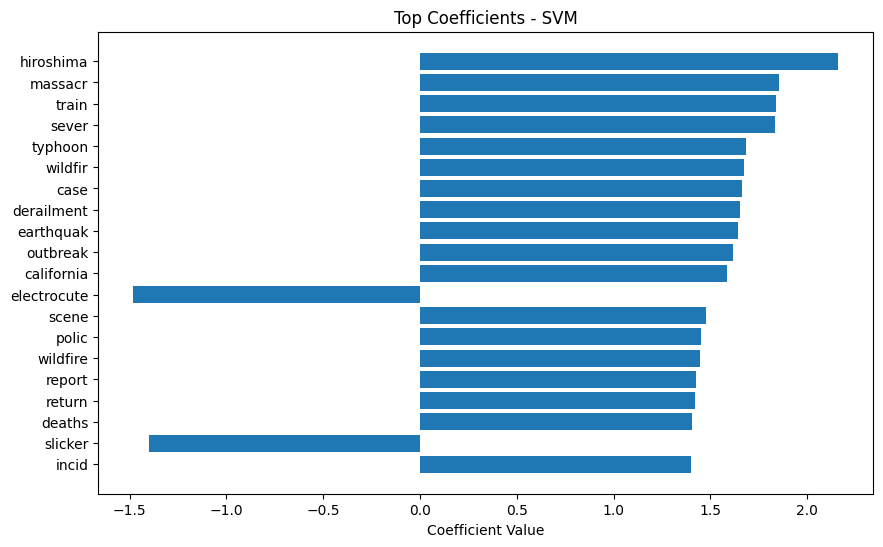

In [64]:
coefficients = results['svc']['model'].coef_.flatten()
indices = np.argsort(np.abs(coefficients))[-20:]

plt.figure(figsize=(10,6))
plt.title('Top Coefficients - SVM')
plt.barh(range(len(indices)), coefficients[indices], align='center')
plt.yticks(range(len(indices)), [tfidf.get_feature_names_out()[i] for i in indices])
plt.xlabel('Coefficient Value')
plt.show()


## Naive Bayes

Naive Bayes is a probabilistic classifier based on Bayes' Theorem, assuming feature independence to efficiently predict class probabilities.


In [65]:
nb = MultinomialNB()
results["nb"] = evaluate_model(nb, 'Naive Bayes', X_train, y_train, X_val, y_val, skf)

In [66]:
print("\nNaive Bayes Results:")

print("\nCross-Validation Report:")
print(results["nb"]["cv_results"]["cv_report"])
print("Mean Cross-Validation Accuracy:", results["nb"]["cv_results"]["cv_mean_accuracy"])

print("\nTrain-Validation Results:")
print("Training Accuracy:", results["nb"]["train_val_results"]["training_accuracy"])
print("Validation Accuracy:", results["nb"]["train_val_results"]["validation_accuracy"])
print("\nValidation Classification Report:")
print(results["nb"]["train_val_results"]["validation_report"])



Naive Bayes Results:

Cross-Validation Report:
              precision    recall  f1-score      support
0              0.763602  0.909642  0.830249  3132.000000
1              0.839660  0.626904  0.717849  2364.000000
accuracy       0.788028  0.788028  0.788028     0.788028
macro avg      0.801631  0.768273  0.774049  5496.000000
weighted avg   0.796317  0.788028  0.781903  5496.000000
Mean Cross-Validation Accuracy: 0.7880292828190918

Train-Validation Results:
Training Accuracy: 0.8606259097525473
Validation Accuracy: 0.7831149927219796

Validation Classification Report:
              precision    recall  f1-score      support
0              0.757158  0.911877  0.827346   783.000000
1              0.839907  0.612521  0.708415   591.000000
accuracy       0.783115  0.783115  0.783115     0.783115
macro avg      0.798533  0.762199  0.767881  1374.000000
weighted avg   0.792751  0.783115  0.776190  1374.000000


`.feature_log_prob_` represents the log probability of each feature (word or n-gram) given a specific class, showing how strongly a word is associated with a class.


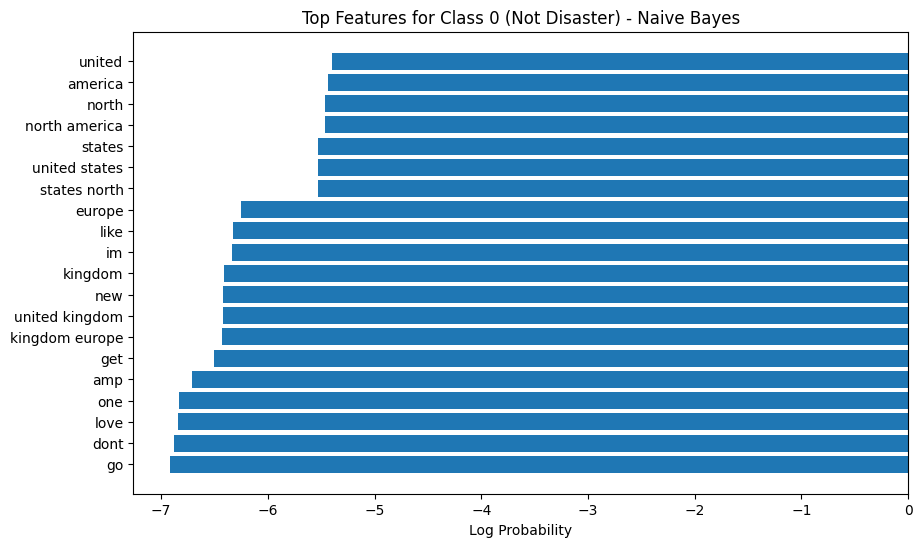

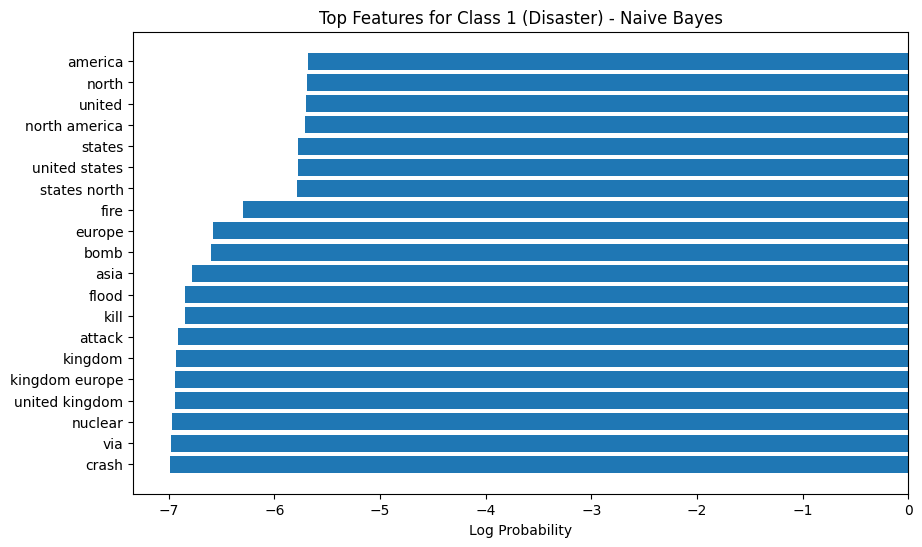

In [67]:
class_labels = results['nb']['model'].classes_
feature_names = tfidf.get_feature_names_out()

topn_class0 = np.argsort(nb.feature_log_prob_[0])[-20:]

plt.figure(figsize=(10,6))
plt.title('Top Features for Class 0 (Not Disaster) - Naive Bayes')
plt.barh(range(len(topn_class0)), nb.feature_log_prob_[0][topn_class0], align='center')
plt.yticks(range(len(topn_class0)), [feature_names[i] for i in topn_class0])
plt.xlabel('Log Probability')
plt.show()

topn_class1 = np.argsort(nb.feature_log_prob_[1])[-20:]

plt.figure(figsize=(10,6))
plt.title('Top Features for Class 1 (Disaster) - Naive Bayes')
plt.barh(range(len(topn_class1)), nb.feature_log_prob_[1][topn_class1], align='center')
plt.yticks(range(len(topn_class1)), [feature_names[i] for i in topn_class1])
plt.xlabel('Log Probability')
plt.show()


## Logistic Regression

Logistic Regression is a linear classification algorithm that predicts probabilities using the sigmoid function, making it effective for binary and multi-class classification tasks.


In [68]:
lr = LogisticRegression(random_state=42)
results["logistic_regression"] = evaluate_model(lr, 'Logistic Regression', X_train, y_train, X_val, y_val, skf)

In [69]:
print("\nLogistic Regression Results:")

print("\nCross-Validation Report:")
print(results["logistic_regression"]["cv_results"]["cv_report"])
print("Mean Cross-Validation Accuracy:", results["logistic_regression"]["cv_results"]["cv_mean_accuracy"])

print("\nTrain-Validation Results:")
print("Training Accuracy:", results["logistic_regression"]["train_val_results"]["training_accuracy"])
print("Validation Accuracy:", results["logistic_regression"]["train_val_results"]["validation_accuracy"])
print("\nValidation Classification Report:")
print(results["logistic_regression"]["train_val_results"]["validation_report"])


Logistic Regression Results:

Cross-Validation Report:
              precision    recall  f1-score     support
0              0.776177  0.894636  0.831207  3132.00000
1              0.825027  0.658206  0.732235  2364.00000
accuracy       0.792940  0.792940  0.792940     0.79294
macro avg      0.800602  0.776421  0.781721  5496.00000
weighted avg   0.797189  0.792940  0.788636  5496.00000
Mean Cross-Validation Accuracy: 0.7929428405988915

Train-Validation Results:
Training Accuracy: 0.8768195050946143
Validation Accuracy: 0.7969432314410481

Validation Classification Report:
              precision    recall  f1-score      support
0              0.785714  0.885057  0.832432   783.000000
1              0.817073  0.680203  0.742382   591.000000
accuracy       0.796943  0.796943  0.796943     0.796943
macro avg      0.801394  0.782630  0.787407  1374.000000
weighted avg   0.799203  0.796943  0.793699  1374.000000


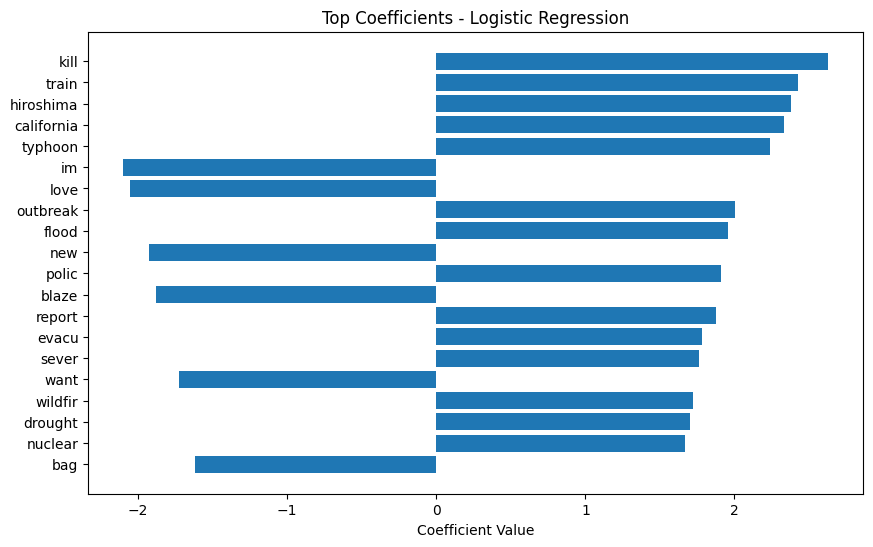

In [70]:
coefficients = results['logistic_regression']['model'].coef_.flatten()
indices = np.argsort(np.abs(coefficients))[-20:]

plt.figure(figsize=(10,6))
plt.title('Top Coefficients - Logistic Regression')
plt.barh(range(len(indices)), coefficients[indices], align='center')
plt.yticks(range(len(indices)), [tfidf.get_feature_names_out()[i] for i in indices])
plt.xlabel('Coefficient Value')
plt.show()


## XGBoost

XGBoost (Extreme Gradient Boosting) is a powerful, optimized gradient boosting algorithm that builds decision trees sequentially to improve predictive accuracy and efficiency.

**Hyperparameter Tuning with RandomizedSearchCV**:

Instead of testing all possible parameter combinations (which can be computationally expensive), it randomly samples from the given parameter distributions to efficiently find the best combination.

- `param_dist`: Defines the hyperparameter search space, including depth, learning rate, number of estimators, and more.
- `RandomizedSearchCV`: Runs 50 random combinations (`n_iter=50`) using 3-fold cross-validation (`cv=3`).
- `rand_search.fit(...)`: Trains the model on `X_train_full` while searching for the best parameters.
- `rand_search.best_params_`: Displays the best hyperparameter combination found.


In [71]:
param_dist = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 500],
    'gamma': [0, 0.1, 0.5, 1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
rand_search = RandomizedSearchCV(xgb.XGBClassifier(random_state=42), param_distributions=param_dist, n_iter=50, cv=3, scoring='accuracy', random_state=42)
#rand_search.fit(X_train_full, y_train_full)
#print("Best Parameters:", rand_search.best_params_)

In [72]:
best_xgb_params = {
    'subsample': 1.0,
    'n_estimators': 500,
    'max_depth': 7,
    'learning_rate': 0.1,
    'gamma': 1,
    'colsample_bytree': 1.0
}

In [73]:
#cleaned_params = {key.replace('xgb__', ''): value for key, value in rand_search.best_params_.items()}
cleaned_params = {key.replace('xgb__', ''): value for key, value in best_xgb_params.items()}

xgb_clf = xgb.XGBClassifier(random_state=42, **cleaned_params)

results["xgboost"] = evaluate_model(xgb_clf, 'XGBoost', X_train, y_train, X_val, y_val, skf)

In [74]:
print("\nXGBoost Results:")

print("\nCross-Validation Report:")
print(results["xgboost"]["cv_results"]["cv_report"])
print("Mean Cross-Validation Accuracy:", results["xgboost"]["cv_results"]["cv_mean_accuracy"])

print("\nTrain-Validation Results:")
print("Training Accuracy:", results["xgboost"]["train_val_results"]["training_accuracy"])
print("Validation Accuracy:", results["xgboost"]["train_val_results"]["validation_accuracy"])
print("\nValidation Classification Report:")
print(results["xgboost"]["train_val_results"]["validation_report"])


XGBoost Results:

Cross-Validation Report:
              precision    recall  f1-score      support
0              0.768904  0.866858  0.814948  3132.000000
1              0.787786  0.654822  0.715177  2364.000000
accuracy       0.775655  0.775655  0.775655     0.775655
macro avg      0.778345  0.760840  0.765062  5496.000000
weighted avg   0.777026  0.775655  0.772033  5496.000000
Mean Cross-Validation Accuracy: 0.7756578707916287

Train-Validation Results:
Training Accuracy: 0.9084788937409025
Validation Accuracy: 0.7641921397379913

Validation Classification Report:
              precision    recall  f1-score      support
0              0.747040  0.886335  0.810748   783.000000
1              0.800000  0.602369  0.687259   591.000000
accuracy       0.764192  0.764192  0.764192     0.764192
macro avg      0.773520  0.744352  0.749003  1374.000000
weighted avg   0.769820  0.764192  0.757631  1374.000000


# Results

In [75]:
accuracy_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV Mean Accuracy': [results[model]['cv_results']['cv_mean_accuracy'] for model in results],
    'Training Accuracy': [results[model]['train_val_results']['training_accuracy'] for model in results],
    'Validation Accuracy': [results[model]['train_val_results']['validation_accuracy'] for model in results]
})

# Overfitting Gap: difference between training and validation accuracy
accuracy_df['Overfitting Gap'] = accuracy_df['Training Accuracy'] - accuracy_df['Validation Accuracy']

accuracy_df = accuracy_df.sort_values(by='Validation Accuracy', ascending=False).reset_index(drop=True)

accuracy_df


,Model,CV Mean Accuracy,Training Accuracy,Validation Accuracy,Overfitting Gap
0,logistic_regression,0.792943,0.876820,0.796943,0.079876
1,nb,0.788029,0.860626,0.783115,0.077511
2,svc,0.784206,0.961608,0.777293,0.184316
3,xgboost,0.775658,0.908479,0.764192,0.144287
4,random_forest,0.773655,0.990721,0.755459,0.235262
5,decision_tree,0.715975,0.990902,0.719068,0.271834


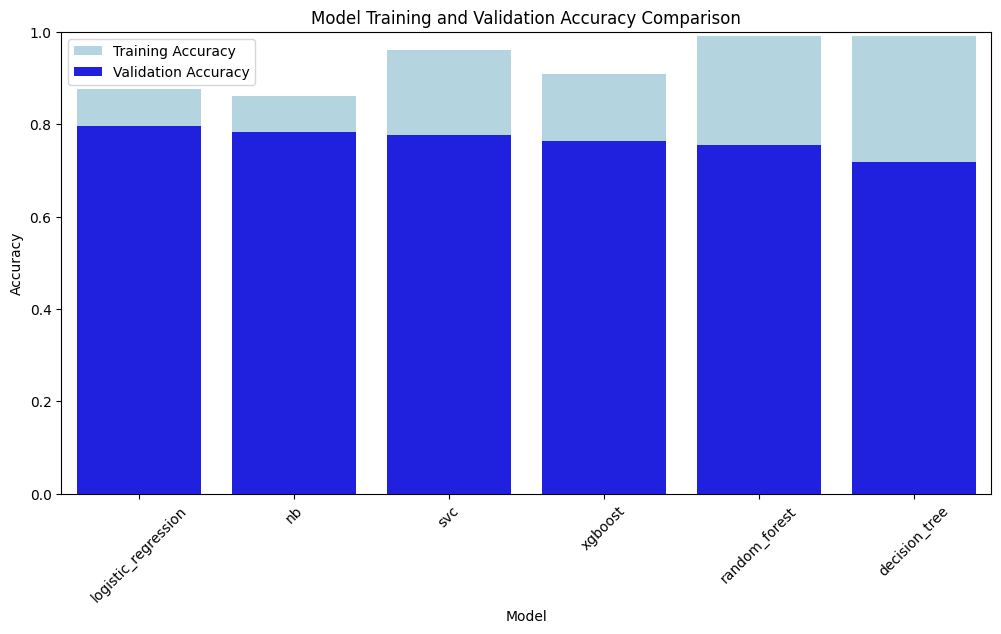

In [76]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Training Accuracy', data=accuracy_df, color='lightblue', label='Training Accuracy')
sns.barplot(x='Model', y='Validation Accuracy', data=accuracy_df, color='blue', label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1.0)
plt.legend()
plt.xticks(rotation=45)
plt.show()

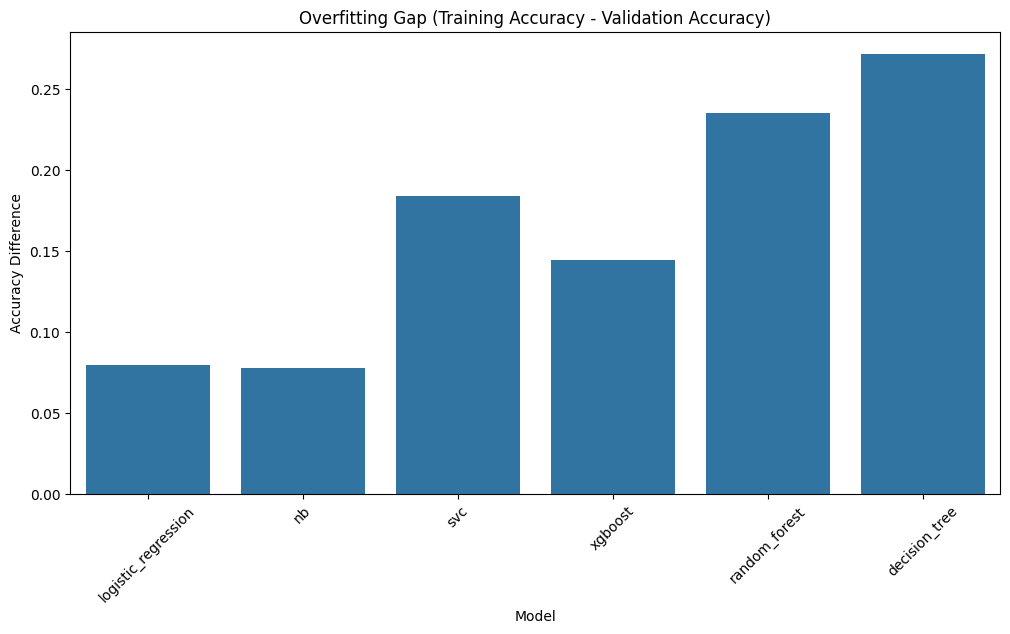

In [77]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Overfitting Gap', data=accuracy_df)
plt.title('Overfitting Gap (Training Accuracy - Validation Accuracy)')
plt.ylabel('Accuracy Difference')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()


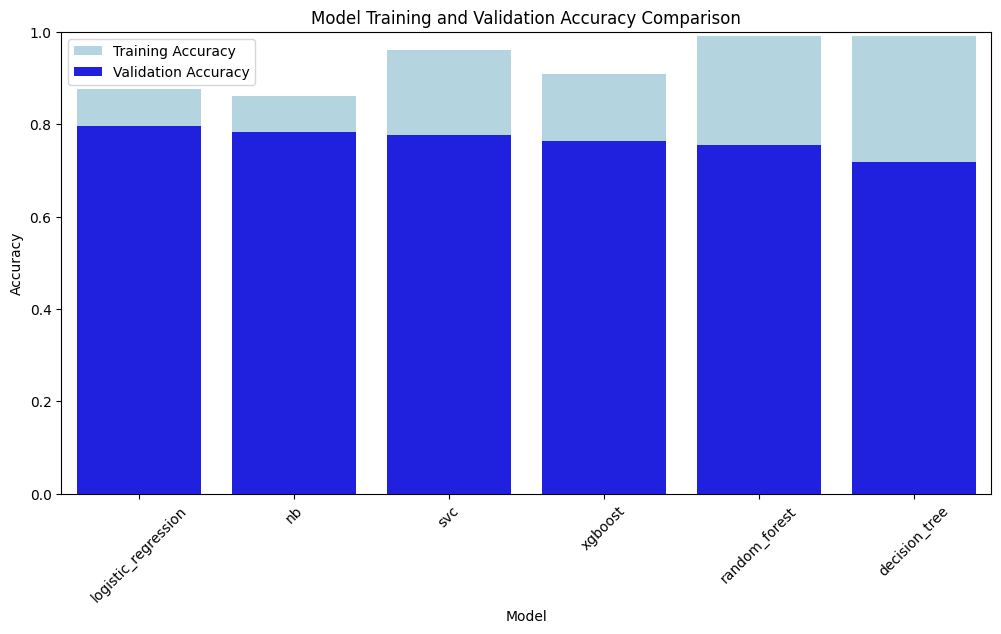

In [78]:
plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='Training Accuracy', data=accuracy_df, color='lightblue', label='Training Accuracy')
sns.barplot(x='Model', y='Validation Accuracy', data=accuracy_df, color='blue', label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1.0)
plt.legend()
plt.xticks(rotation=45)
plt.show()


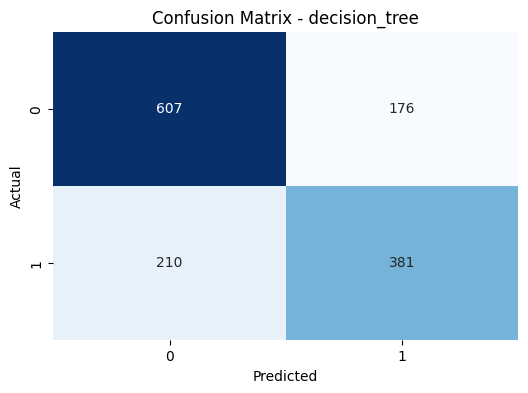

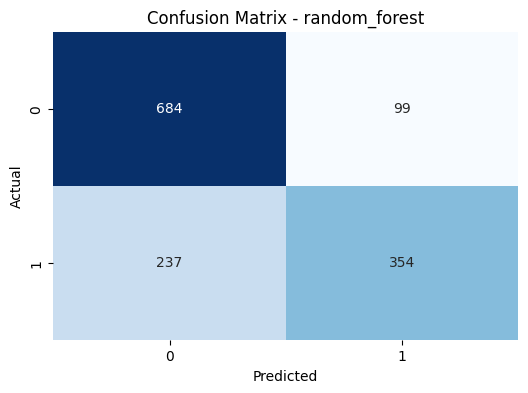

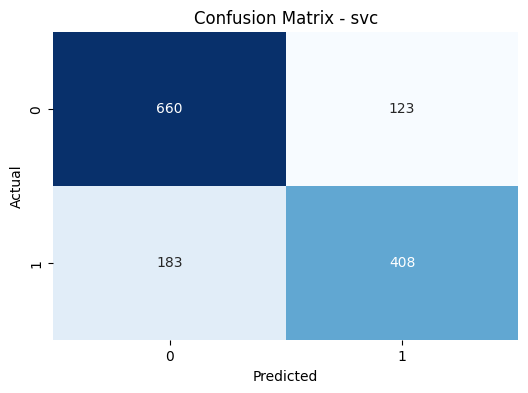

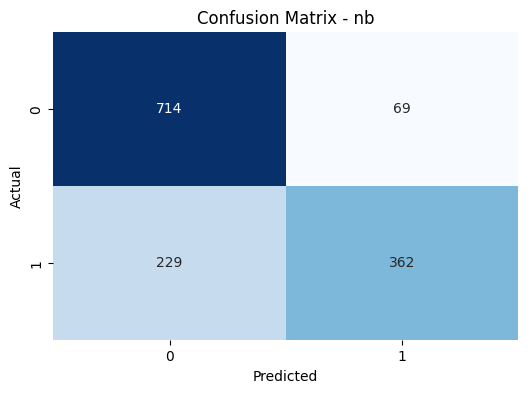

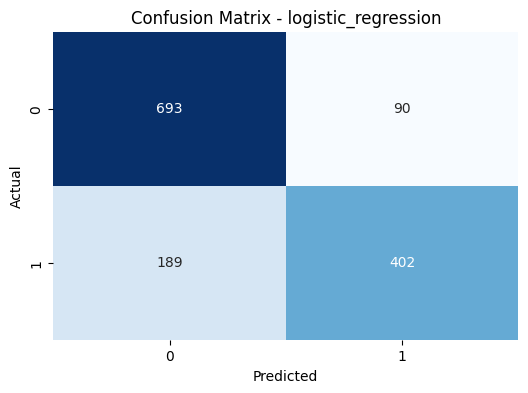

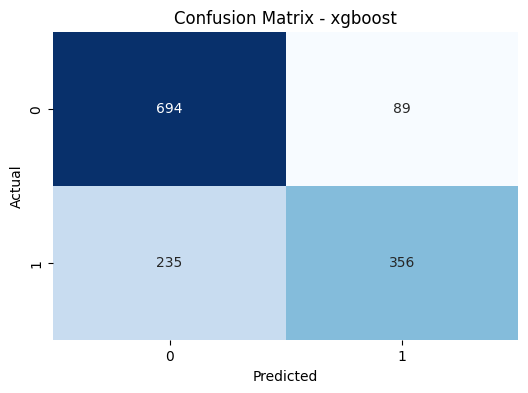

In [79]:
for model_name, model_data in results.items():
    y_pred_val = model_data['train_val_results']['validation_predictions']  # Updated key

    conf_matrix = confusion_matrix(y_val, y_pred_val)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


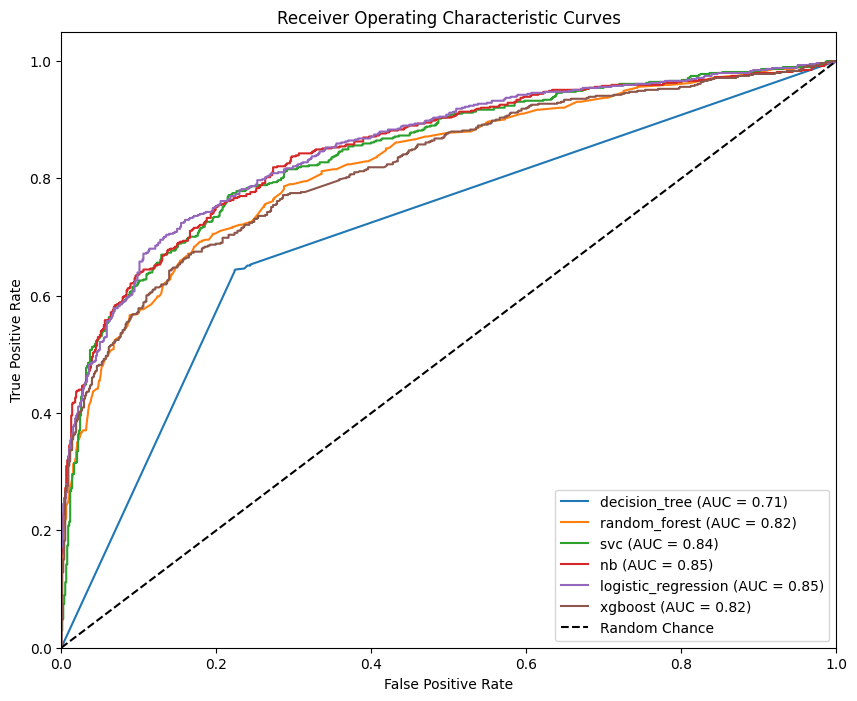

In [80]:
roc_results = {}

for model_name, model_data in results.items():
    model = model_data['model']

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred_proba = model.decision_function(X_val)
    else:
        print(f"Model {model_name} does not have predict_proba or decision_function method.")
        continue

    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    roc_results[model_name] = (fpr, tpr, roc_auc)

plt.figure(figsize=(10, 8))

for model_name, (fpr, tpr, roc_auc) in roc_results.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [81]:
for model_name, model_data in results.items():
    model = model_data['model']

    y_test_pred = model.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    model_data['test_results'] = {
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_report': pd.DataFrame(test_report).transpose()
    }

comparison_df = pd.DataFrame({
    'Model': [model_name for model_name in results],
    'Training Accuracy': [results[model]['train_val_results']['training_accuracy'] for model in results],
    'Validation Accuracy': [results[model]['train_val_results']['validation_accuracy'] for model in results],
    'Test Accuracy': [results[model]['test_results']['test_accuracy'] for model in results]
})

comparison_df = comparison_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)

print(comparison_df)

                 Model  Training Accuracy  Validation Accuracy  Test Accuracy
0                   nb           0.860626             0.783115       0.812827
1  logistic_regression           0.876820             0.796943       0.811518
2              xgboost           0.908479             0.764192       0.799738
3        random_forest           0.990721             0.755459       0.781414
4                  svc           0.961608             0.777293       0.769634
5        decision_tree           0.990902             0.719068       0.726440


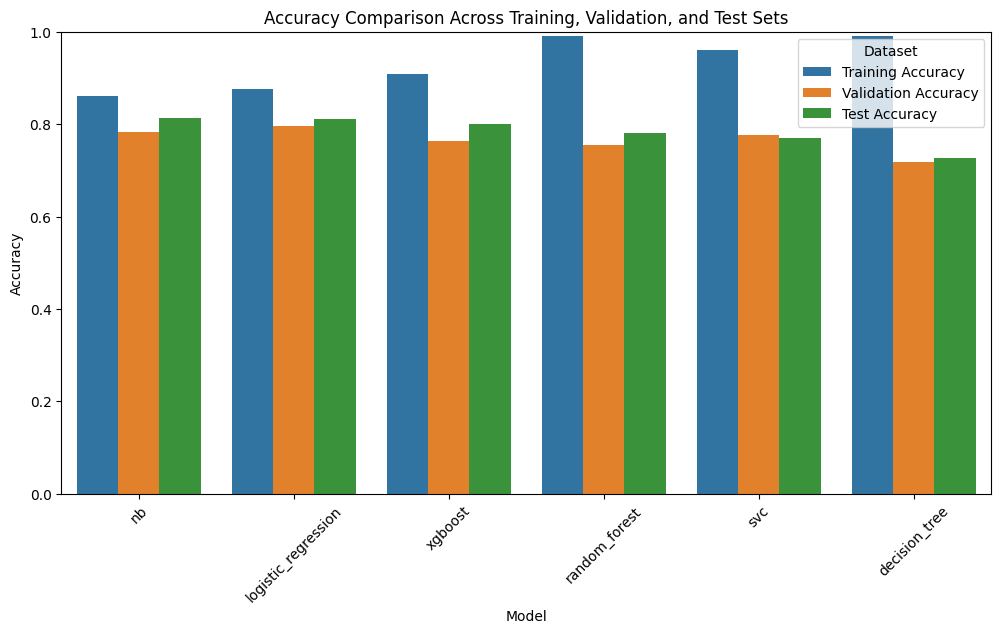

In [82]:
comparison_melted = comparison_df.melt(id_vars='Model', var_name='Dataset', value_name='Accuracy')

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=comparison_melted)
plt.title('Accuracy Comparison Across Training, Validation, and Test Sets')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.legend(title='Dataset')
plt.show()


## Sample submission Logistic Regression

In [83]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [84]:
y_pred_submission = lr.predict(X_submission)

In [93]:
sample_submission_lr = sample_submission.copy()
sample_submission_lr['target'] = y_pred_submission

sample_submission_lr.to_csv(folder_path + 'data/submissions/submission_lr.csv', index=False)

sample_submission_lr.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


# Torch Imports

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# LSTM

In [124]:
def simple_tokenize(text):
    return text.lower().split()

## Tokenization and Vocabulary

1. **Extract Text and Labels**  
   - `X_text`: Extracts the combined text data from `train_df`.  
   - `y`: Extracts the target labels (0 or 1) for classification.  

2. **Splitting into Training, Validation, and Test Sets**  
   - `train_test_split(..., test_size=0.1)`: Reserves **10% of the data for testing (`X_test_dl`, `y_test_dl`)**.
   - `train_test_split(..., test_size=0.2)`: Further splits the remaining **90% into:**
     - **80% for training (`X_train_dl`, `y_train_dl`)**  
     - **20% for validation (`X_val_dl`, `y_val_dl`)**  
   - `stratify=y` ensures the class distribution remains balanced in all sets.  

3. **Tokenizing the Text for Deep Learning**  
   - `simple_tokenize(t)`: Converts each text sample into a list of lowercase words.  
   - This is applied to:  
     - `X_train_tokens_dl`: Tokenized training data.  
     - `X_val_tokens_dl`: Tokenized validation data.  
     - `X_test_tokens_dl`: Tokenized test data (from the newly created labeled test set).  


In [175]:
X_text_dl = train_df['combined_text'].values
y_dl = train_df['target'].values
X_submission_dl = test_df['combined_text'].values

X_train_val_dl, X_test_dl, y_train_val_dl, y_test_dl = train_test_split(
    X_text, y, test_size=0.1, random_state=42, stratify=y  # 10% for testing
)

X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_train_val_dl, y_train_val_dl, test_size=0.2, random_state=42, stratify=y_train_val_dl  # 20% of remaining for validation
)

X_train_tokens_dl = [simple_tokenize(t) for t in X_train_dl]
X_val_tokens_dl = [simple_tokenize(t) for t in X_val_dl]
X_test_tokens_dl = [simple_tokenize(t) for t in X_test_dl]
X_submission_tokens_dl = [simple_tokenize(t) for t in X_submission_dl]

In [126]:
X_train_dl

array(['wreckage wreckag conclus confirm mh malaysia pm investig famili - Mumbai India Asia',
       'desolate understand broke ppl mad alway hav attitud sht aint fun wont desol long - Chicago United States North America',
       'burned joke wood burn work mani inning often - Chicago United States North America',
       ..., 'obliteration would say im dead im right obliter -   ',
       'hurricane cape coral citi leader take part mock hurrican train -   ',
       'fear coupl less sex fear itll let internet movi book say sex ought p -   '],
      dtype=object)

Building a Vocabular:

1. **Count Word Frequencies**  
   - Iterates through the tokenized training dataset (`X_train_tokens_dl`).  
   - Stores the count of each word in `word_freq_dl`.  

2. **Sort Words by Frequency**  
   - `sorted_words_dl`: Sorts the words based on how often they appear, from most to least frequent.  

3. **Define Special Tokens**  
   - `PAD_IDX = 0`: Reserved for padding sequences to equal length.  
   - `UNK_IDX = 1`: Represents unknown words not found in the training vocabulary.  

4. **Create a Vocabulary Mapping**  
   - `vocab_dl`: Assigns an index to each word, starting from **index 2** (0 and 1 are reserved).  
   - `vocab_size_dl`: Total vocabulary size, including special tokens.  


In [127]:
word_freq = {}
for tokens in X_train_tokens_dl:
    for tok in tokens:
        word_freq[tok] = word_freq.get(tok, 0) + 1

sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

PAD_IDX = 0  # Padding token index
UNK_IDX = 1  # Unknown word token index

vocab = {w[0]: i + 2 for i, w in enumerate(sorted_words)}  # Start indexing from 2
vocab_size = len(vocab) + 2  # Account for PAD and UNK tokens


In [128]:
vocab

{'-': 2,
 'united': 3,
 'america': 4,
 'north': 5,
 'states': 6,
 'europe': 7,
 'kingdom': 8,
 'new': 9,
 'fire': 10,
 'like': 11,
 'asia': 12,
 'get': 13,
 'im': 14,
 'amp': 15,
 'bomb': 16,
 'via': 17,
 'africa': 18,
 'flood': 19,
 'one': 20,
 'canada': 21,
 'peopl': 22,
 'attack': 23,
 'crash': 24,
 'go': 25,
 'burn': 26,
 'fatal': 27,
 'dont': 28,
 'kill': 29,
 'us': 30,
 'australia': 31,
 'york': 32,
 'time': 33,
 'video': 34,
 'bodi': 35,
 'build': 36,
 'say': 37,
 'emerg': 38,
 'disast': 39,
 'derail': 40,
 'india': 41,
 'storm': 42,
 'death': 43,
 'year': 44,
 'look': 45,
 'polic': 46,
 'weapon': 47,
 'day': 48,
 'dead': 49,
 'wreck': 50,
 'drown': 51,
 'train': 52,
 'see': 53,
 'make': 54,
 'love': 55,
 'home': 56,
 'still': 57,
 'evacu': 58,
 'california': 59,
 'destroy': 60,
 'would': 61,
 'fear': 62,
 'london': 63,
 'back': 64,
 'famili': 65,
 'know': 66,
 'south': 67,
 'bag': 68,
 'come': 69,
 'watch': 70,
 'hijack': 71,
 'news': 72,
 'man': 73,
 'want': 74,
 'think': 75,


Converting Tokens to Numerical Indices:

- This function maps a list of tokenized words into their corresponding numerical indices using the vocabulary (`vocab_dl`).
- If a word exists in the vocabulary, it is replaced with its assigned index.
- If a word is **not** in the vocabulary, it is replaced with `UNK_IDX` (index for unknown words).


In [129]:
def tokens_to_indices(tokens, vocab, unk_idx=UNK_IDX):
    return [vocab.get(t, unk_idx) for t in tokens]

In [130]:
tokens_to_indices(['low', 'vehicl'], vocab)

[998, 1000]

In [131]:
print("Class 0 count:", sum(y_train_dl == 0))
print("Class 1 count:", sum(y_train_dl == 1))


Class 0 count: 3132
Class 1 count: 2364


## PyTorch Dataset and Dataloaders

1. **Custom Dataset Class (`TextDataset`)**  
   - Takes tokenized texts, labels, vocabulary, and maximum sequence length.  
   - Converts words to numerical indices using `tokens_to_indices()`.  
   - Pads sequences with `PAD_IDX` if they are shorter than `max_len` or truncates them if they exceed `max_len`.  
   - Returns **tensor representations** of text sequences and their corresponding labels.

2. **Dataset Initialization**  
   - `train_dataset`: Contains tokenized training data (`X_train_tokens_dl`, `y_train_dl`).  
   - `val_dataset`: Contains tokenized validation data (`X_val_tokens_dl`, `y_val_dl`).  
   - `test_dataset`: Contains tokenized test data (`X_test_tokens_dl`, `y_test_dl`).  
   - All datasets are transformed into PyTorch tensors for efficient processing.

3. **DataLoaders for Mini-Batch Training**  
   - `train_loader`: Loads training data in shuffled mini-batches for better generalization.  
   - `val_loader`: Loads validation data without shuffling to maintain sequence consistency.  
   - `test_loader`: Loads test data without shuffling for final model evaluation.

In [150]:
class TextDataset(Dataset):
    def __init__(self, tokenized_texts, labels, vocab, max_len=50):
        self.tokenized_texts = tokenized_texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tokens = self.tokenized_texts[idx]
        indices = tokens_to_indices(tokens, self.vocab)
        if len(indices) < self.max_len:
            indices += [PAD_IDX] * (self.max_len - len(indices))  # Pad if shorter
        else:
            indices = indices[:self.max_len]  # Truncate if longer
        return torch.tensor(indices, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# Sequence length
max_len = 80

train_dataset = TextDataset(X_train_tokens_dl, y_train_dl, vocab, max_len)
val_dataset = TextDataset(X_val_tokens_dl, y_val_dl, vocab, max_len)
test_dataset = TextDataset(X_test_tokens_dl, y_test_dl, vocab, max_len)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



## Model Definition

1. **LSTM Model (`LSTMClassifier`)**
   - `nn.Embedding`: Converts word indices into dense vector representations.
   - `nn.LSTM`: Processes sequential word embeddings to capture context.
   - `nn.Linear`: Fully connected layer to output class predictions.

2. **Model Hyperparameters**
   - `embed_dim`: Size of word embeddings (default: 100).
   - `hidden_dim`: Number of hidden units in LSTM (default: 128).
   - `num_classes`: Output classes (binary classification → 2).

3. **Training Setup**
   - `criterion = nn.CrossEntropyLoss()`: Defines loss function for classification.
   - `optimizer = optim.Adam(model.parameters(), lr=0.04)`: Optimizes model using Adam.

In [133]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128, num_layers=1, num_classes=2):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (h, _) = self.lstm(embedded)
        h = h[-1]  # Take the last hidden state
        out = self.fc(h)
        return out

# Model hyperparameters
embed_dim = 80
hidden_dim = 128
num_classes = 2
num_layers = 1

model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, num_layers, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


LSTMClassifier(
  (embedding): Embedding(9514, 80, padding_idx=0)
  (lstm): LSTM(80, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

## Training

1. **evaluate_model(model, loader, criterion, device)**
   - Puts the model in evaluation mode (`model.eval()`).
   - Iterates over batches in the validation or test set.
   - Computes loss and accuracy without updating gradients (`torch.no_grad()`).
   - Returns the **accuracy and average loss**.

2. **train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=20)**
   - Loops through `epochs=20` to train the model.
   - For each batch:
     - Moves data to `device` (CPU/GPU).
     - Performs forward pass, computes loss, and updates weights.
   - Evaluates accuracy on the validation set.
   - Saves the **best model checkpoint** (`best_model.pt`) when validation accuracy improves.

3. **Training Execution**
   - Calls `train_model()` to start training for 20 epochs.

In [134]:
print("Train Loader Details:")
print("Number of batches:", len(train_loader))

for i, (inputs, labels) in enumerate(train_loader):
    print(f"\nBatch {i+1}:")
    print("Input tensor shape:", inputs.shape)
    print("Sample input tensor:", inputs[0])
    print("Labels shape:", labels.shape)
    print("Sample label:", labels[0])
    if i == 2:
      break

print("\nVocabulary size:", vocab_size)
print("Max sequence length:", max_len)
print("Batch size:", batch_size)



Train Loader Details:
Number of batches: 86

Batch 1:
Input tensor shape: torch.Size([64, 80])
Sample input tensor: tensor([ 269,  353, 5556, 3661,  438, 3662,   85,  269,   13,  549,    2, 1258,
           7,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
Labels shape: torch.Size([64])
Sample label: tensor(0)

Batch 2:
Input tensor shape: torch.Size([64, 80])
Sample input tensor: tensor([ 205,   20, 7289,   25, 3949, 7290,  634,  205, 2297,   55, 1352, 1102,
           2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0

In [135]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += X_batch.size(0)
    return correct / total, total_loss / total

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=20):
    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()
            train_total += X_batch.size(0)

        train_acc = train_correct / train_total
        val_acc, val_loss = evaluate_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pt')

    print("Training complete. Best validation accuracy:", best_val_acc)

train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=20)

Epoch 1: Train Acc: 0.5295, Val Acc: 0.5801
Epoch 2: Train Acc: 0.6736, Val Acc: 0.6718
Epoch 3: Train Acc: 0.8137, Val Acc: 0.7096
Epoch 4: Train Acc: 0.8750, Val Acc: 0.7263
Epoch 5: Train Acc: 0.9138, Val Acc: 0.6951
Epoch 6: Train Acc: 0.9332, Val Acc: 0.6841
Epoch 7: Train Acc: 0.9465, Val Acc: 0.6965
Epoch 8: Train Acc: 0.9521, Val Acc: 0.7191
Epoch 9: Train Acc: 0.9572, Val Acc: 0.7125
Epoch 10: Train Acc: 0.9592, Val Acc: 0.7038
Epoch 11: Train Acc: 0.9638, Val Acc: 0.7045
Epoch 12: Train Acc: 0.9649, Val Acc: 0.6834
Epoch 13: Train Acc: 0.9616, Val Acc: 0.7031
Epoch 14: Train Acc: 0.9636, Val Acc: 0.7125
Epoch 15: Train Acc: 0.9663, Val Acc: 0.6980
Epoch 16: Train Acc: 0.9665, Val Acc: 0.7031
Epoch 17: Train Acc: 0.9671, Val Acc: 0.7052
Epoch 18: Train Acc: 0.9654, Val Acc: 0.7089
Epoch 19: Train Acc: 0.9636, Val Acc: 0.7038
Epoch 20: Train Acc: 0.9643, Val Acc: 0.7162
Training complete. Best validation accuracy: 0.7263464337700145


## Evaluation


Loading and Evaluating the Trained LSTM Model on Test Data:

1. **Load the Best Model Checkpoint**
   - Uses `torch.load('best_model.pt', map_location=device)` to load the model that achieved the highest validation accuracy.
   - Ensures compatibility with `device` (CPU or GPU).

2. **Set Model to Evaluation Mode**
   - `model.eval()` disables dropout and batch normalization layers, ensuring stable predictions.

3. **Evaluate the Model on Test Data**
   - Calls `evaluate_model(model, test_loader, criterion, device)` to compute:
     - `test_acc`: Final test accuracy.
     - `test_loss`: Average loss over the test set.

4. **Print Final Test Accuracy**
   - Displays the model's performance on unseen data.

This step provides the final performance evaluation, ensuring that the trained LSTM model generalizes well to real-world test samples.


In [136]:
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.eval()

test_acc, test_loss = evaluate_model(model, test_loader, criterion, device)
print("Test Accuracy:", test_acc)


Test Accuracy: 0.7382198952879581


## Classification report

1. **get_predictions(model, loader, device)**
   - Puts the model in **evaluation mode** (`model.eval()`).
   - Iterates through the dataset batch by batch.
   - Moves inputs to the correct `device` (CPU or GPU).
   - Predicts labels using `torch.max(outputs, 1)`, extracting the most likely class.
   - Converts predictions to NumPy arrays for compatibility with `sklearn.metrics`.

2. **Evaluate on Validation and Test Sets**
   - Calls `get_predictions(model, val_loader, device)` for validation predictions.
   - Calls `get_predictions(model, test_loader, device)` for test predictions.
   - Uses `classification_report()` to generate precision, recall, F1-score, and accuracy.

3. **Prints Classification Reports**
   - Provides a detailed breakdown of model performance for both validation and test data.

In [137]:
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu().numpy()
            y_batch = y_batch.numpy()
            all_preds.extend(preds)
            all_targets.extend(y_batch)
    return all_preds, all_targets

val_preds, val_targets = get_predictions(model, val_loader, device)
print("Classification Report (Validation):\n", classification_report(val_targets, val_preds, digits=4))

test_preds, test_targets = get_predictions(model, test_loader, device)
print("Classification Report (Test):\n", classification_report(test_targets, test_preds, digits=4))


Classification Report (Validation):
               precision    recall  f1-score   support

           0     0.7058    0.8914    0.7878       783
           1     0.7792    0.5076    0.6148       591

    accuracy                         0.7263      1374
   macro avg     0.7425    0.6995    0.7013      1374
weighted avg     0.7374    0.7263    0.7134      1374

Classification Report (Test):
               precision    recall  f1-score   support

           0     0.7117    0.9080    0.7980       435
           1     0.8086    0.5137    0.6283       329

    accuracy                         0.7382       764
   macro avg     0.7602    0.7109    0.7131       764
weighted avg     0.7534    0.7382    0.7249       764



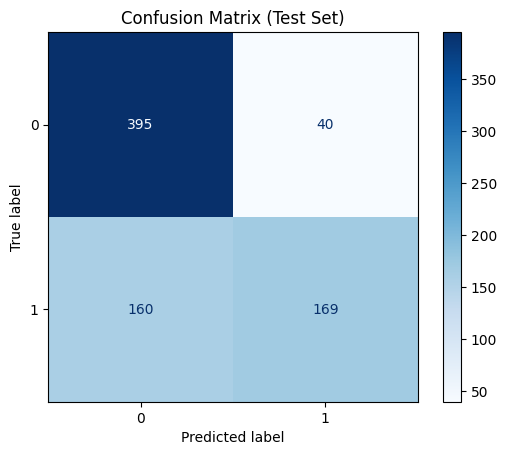

In [138]:
cm = confusion_matrix(test_targets, test_preds)

disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()


## Sample submission LSTM

In [139]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [176]:
X_submission_dataset = TextDataset(X_submission_tokens_dl, [0] * len(X_submission_tokens_dl), vocab, max_len) # Dummy labels for submission
X_submission_loader = DataLoader(X_submission_dataset, batch_size=batch_size, shuffle=False)

def get_submission_predictions(model, loader, device):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for X_batch, _ in loader:  # Ignore dummy labels
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu().numpy()
            all_preds.extend(preds)
    return all_preds

y_pred_submission_lstm = get_submission_predictions(model, X_submission_loader, device)

sample_submission_lstm = sample_submission.copy()
sample_submission_lstm['target'] = y_pred_submission_lstm


In [178]:
sample_submission_lstm.to_csv(folder_path + 'data/submissions/sample_submission_lstm.csv', index=False)

sample_submission_lstm.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


# DestilBert

In [56]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

1. **Custom Dataset Class (`BertDataset`)**  
   - Prepares text data for **BERT-based models** by converting raw text into tokenized tensors.  
   - Uses a **Hugging Face tokenizer** to process text into BERT-compatible inputs.  
   - Stores tokenized text sequences (`input_ids`), attention masks (`attention_mask`), and labels (`labels`).

2. **Initialization (`__init__`)**  
   - `texts`: The input text samples.  
   - `labels`: Corresponding target labels (0 or 1 for classification).  
   - `tokenizer`: The tokenizer (e.g., `BertTokenizer` or `AutoTokenizer`).  
   - `max_length`: The maximum sequence length for tokenization (default: 128).  

3. **Dataset Length (`__len__`)**  
   - Returns the number of text samples in the dataset.

4. **Tokenization and Encoding (`__getitem__`)**  
   - Converts the text into a **string** (ensures compatibility).  
   - Converts labels to integers for tensor processing.  
   - Uses `self.tokenizer.encode_plus()` to:  
     - Add **special tokens** (`[CLS]` at the beginning, `[SEP]` at the end).  
     - **Truncate** longer sequences and **pad** shorter ones to `max_length`.  
     - Generate an **attention mask** (helps BERT ignore padded tokens).  
     - Return tensors in **PyTorch format (`return_tensors='pt'`)**.  

5. **Returned Dictionary for Model Input**  
   - `'input_ids'`: Tensor of tokenized word indices.  
   - `'attention_mask'`: Tensor indicating which tokens should be attended to (1) or ignored (0).  
   - `'labels'`: Target class label as a tensor.  


In [57]:
class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels  # Can be None for submission data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        if self.labels is not None:
            label = int(self.labels[idx])
            item['labels'] = torch.tensor(label, dtype=torch.long)
        return item


1. **Extract Text and Labels**  
   - `X_text_bert`: Extracts the combined text data from `train_df` for BERT processing.  
   - `y_bert`: Extracts the target labels (0 or 1) for classification.  

2. **Creating a Training and Temporary Set**  
   - `train_test_split(..., test_size=0.1)`:  
     - Reserves **10% of the dataset for validation and test (`X_temp_bert`, `y_temp_bert`)**.  
     - The remaining **90% is used for training (`X_train_bert`, `y_train_bert`)**.  
     - `stratify=y_bert` ensures class distribution remains balanced.  

3. **Splitting Validation and Test Sets**  
   - `train_test_split(..., test_size=0.5)`:  
     - Splits the **temporary 10% into validation (50%) and test (50%)**.  
     - Ensures **validation (`X_val_bert`, `y_val_bert`) and test (`X_test_bert`, `y_test_bert`) each receive 5% of the total data**.  
     - `stratify=y_temp_bert` maintains class balance.

### **Final Data Distribution**
| Dataset  | Percentage of Data |
|----------|-------------------|
| **Training (`X_train_bert`, `y_train_bert`)** | 90% |
| **Validation (`X_val_bert`, `y_val_bert`)** | 5% |
| **Test (`X_test_bert`, `y_test_bert`)** | 5% |

In [58]:
X_text_bert = train_df['combined_text'].values
y_bert = train_df['target'].values

X_submission_bert = test_df['combined_text'].values

X_train_bert, X_temp_bert, y_train_bert, y_temp_bert = train_test_split(
    X_text_bert, y_bert, test_size=0.1, random_state=42, stratify=y_bert
)
X_val_bert, X_test_bert, y_val_bert, y_test_bert = train_test_split(
    X_temp_bert, y_temp_bert, test_size=0.5, random_state=42, stratify=y_temp_bert
)


1. **Initialize a Pretrained Tokenizer**  
   - `tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')`  
   - Loads a **DistilBERT tokenizer** that processes text into tokenized input for the `distilbert-base-uncased` model.  
   - Converts words into numerical token IDs and handles special tokens like `[CLS]` and `[SEP]`.  

2. **Creating Tokenized Datasets**  
   - The `BertDataset` class is used to prepare data for PyTorch.  
   - **Each dataset is tokenized and padded** to a fixed length (`max_length=128`) for consistency.  

3. **Dataset Assignments**
   - `train_dataset_bert`: Tokenized training dataset from (`X_train_bert`, `y_train_bert`).  
   - `val_dataset_bert`: Tokenized validation dataset from (`X_val_bert`, `y_val_bert`).  
   - `test_dataset_bert`: Tokenized test dataset from (`X_test_bert`, `y_test_bert`).  


In [59]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_dataset_bert = BertDataset(X_train_bert, y_train_bert, tokenizer, max_length=128)
val_dataset_bert = BertDataset(X_val_bert, y_val_bert, tokenizer, max_length=128)
test_dataset_bert = BertDataset(X_test_bert, y_test_bert, tokenizer, max_length=128)
submission_dataset_bert = BertDataset(X_submission_bert, labels=None, tokenizer=tokenizer, max_length=128)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [60]:
model_bert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **1. `TrainingArguments`**
- `output_dir='./bert_results'`: Saves model checkpoints and training outputs in this directory.  
- `num_train_epochs=6`: Trains the model for **6 full epochs** over the dataset.  
- `per_device_train_batch_size=16`: Uses a batch size of **16 per GPU/CPU** for training.  
- `per_device_eval_batch_size=16`: Uses a batch size of **16 for evaluation** (validation & test).  
- `evaluation_strategy='epoch'`: Runs evaluation **after every epoch** to monitor performance.  
- `save_strategy='epoch'`: Saves the model **after every epoch** (useful for checkpointing).  
- `logging_dir='./bert_logs'`: Stores logs for monitoring training progress.  
- `logging_steps=10`: Logs training metrics **every 10 steps** during training.  
- `load_best_model_at_end=True`: Automatically loads the best model at the end of training.  
- `metric_for_best_model='accuracy'`: Uses **accuracy** as the main evaluation metric.  
- `report_to=[]`: Disables automatic reporting to external logging platforms like **WandB** or **TensorBoard**.  

### **2. `compute_metrics`**
- `labels = pred.label_ids`: Extracts the true class labels.  
- `preds = pred.predictions.argmax(-1)`: Converts model logits into **predicted class labels** (0 or 1).  
- Computes standard **classification metrics** using `sklearn.metrics`:  
  - **Accuracy** (`accuracy_score`): Measures overall correctness.  
  - **Precision** (`precision_score`): Measures how many predicted positives were correct.  
  - **Recall** (`recall_score`): Measures how many actual positives were correctly identified.  
  - **F1-score** (`f1_score`): Balances precision and recall for a combined performance metric.  


In [61]:
training_args = TrainingArguments(
    output_dir='./bert_results',
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./bert_logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to=[]
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
         'accuracy': acc,
         'f1': f1,
         'precision': precision,
         'recall': recall
    }


### **1. Initializing the Trainer**
The `Trainer` class from **Hugging Face's `transformers` library** simplifies training, evaluation, and fine-tuning for Transformer models.

- `model=model_bert`: Uses the **DistilBERT model** for fine-tuning.  
- `args=training_args`: Passes the training configuration (e.g., batch size, logging, evaluation strategy).  
- `train_dataset=train_dataset_bert`: Uses the **tokenized training dataset** for learning.  
- `eval_dataset=val_dataset_bert`: Uses the **tokenized validation dataset** for evaluation at the end of each epoch.  
- `compute_metrics=compute_metrics`: Applies the **custom evaluation function** to compute accuracy, precision, recall, and F1-score.

### **2. Training the Model**
- Begins the **fine-tuning process** using the DistilBERT model.  
- Automatically handles **gradient accumulation, weight updates, and learning rate scheduling**.  
- Saves the **best model checkpoint** based on validation accuracy.

### **3. Evaluating on the Test Set**
- `eval_results = trainer.evaluate(eval_dataset=test_dataset_bert)`:  
  - Runs final evaluation on the **unseen test dataset (`test_dataset_bert`)**.  
  - Uses the same **tokenization and preprocessing** as training data.  
  - Computes **accuracy, precision, recall, and F1-score**.  
- `print("DistilBERT Test Results:", eval_results)`: Displays test performance metrics.



In [62]:
trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset_bert,
    eval_dataset=val_dataset_bert,
    compute_metrics=compute_metrics,
)

trainer.train()

eval_results = trainer.evaluate(eval_dataset=test_dataset_bert)
print("DistilBERT Test Results:", eval_results)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.367600,0.465593,0.798429,0.727915,0.872881,0.624242
2,0.354700,0.464407,0.816754,0.769737,0.841727,0.709091
3,0.244400,0.616745,0.801047,0.750000,0.820144,0.690909


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.367600,0.465593,0.798429,0.727915,0.872881,0.624242
2,0.354700,0.464407,0.816754,0.769737,0.841727,0.709091
3,0.244400,0.616745,0.801047,0.750000,0.820144,0.690909
4,0.236900,0.770142,0.777487,0.757835,0.715054,0.806061
5,0.090000,0.840969,0.801047,0.765432,0.779874,0.751515
6,0.071300,0.940628,0.801047,0.761006,0.790850,0.733333


DistilBERT Test Results: {'eval_loss': 0.4236578941345215, 'eval_accuracy': 0.8298429319371727, 'eval_f1': 0.7962382445141066, 'eval_precision': 0.8193548387096774, 'eval_recall': 0.774390243902439, 'eval_runtime': 69.6613, 'eval_samples_per_second': 5.484, 'eval_steps_per_second': 0.345, 'epoch': 6.0}


## Sample Submission BERT

In [63]:
submission_outputs = trainer.predict(submission_dataset_bert)
y_pred_submission_bert = submission_outputs.predictions.argmax(-1)

sample_submission_bert = sample_submission.copy()
sample_submission_bert['target'] = y_pred_submission_bert
sample_submission_bert.to_csv(folder_path + 'data/submissions/sample_submission_bert.csv', index=False)

sample_submission_bert.head()


,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1
